# GeoErrors `Preprocessing` for New Data

### Jan. 2021

Used to 

Creates training, testing, and validation tensors using `lib.Tiling`. Also used to configure CRS for source data.



---

In [1]:
### Define folders for input/output

# Folder with source data
source_folder = '/data/GeometricErrors/Set2/latest'

# Folder to save all tensor configurations as sub folders
root_tensor_folder = '/data/GeometricErrors/tests/set2_tensors'

In [2]:
### Set Hyperparameters
 
# Define split for raster scene. (testing area = (rs), training area = (1-rs))
raster_split = 0.5

# Buffers for labels (in meters)
label_buffer = 10

# Target number of tiles for each set
test_target = 200
train_target = 500
val_target = 150

# Optionally save polygon representation of sampled windows
save_polys = True

## Loading Modules and Data

We load public modules `geopandas` and `rasterio` to open the respective source data. Locally created modules handle the tiling into training, validation, and testing tensors.   

In [4]:
### Load Data to produce tiled tensors
import os, sys
import numpy as np
import rasterio as rio
import geopandas as gpd
import lib.raster_parse as rp
import lib.Tiling as t

""" Preparing Test """
# Index for tensor set
set_idx = len(os.listdir(root_tensor_folder))

# Folder to save this set of tensors
tensor_folder = '{}/tensor_set_{:02}'.format(root_tensor_folder, set_idx)
if not os.path.exists(tensor_folder):
    os.mkdir(tensor_folder)
else:
    print("Tensor Folder already exists. Exiting")
    sys.exit(0)

    
""" Rasters """
# Split rasters from full scene
merged_raster = rio.open('{}/warp_merged.tif'.format(source_folder))
test_raster, train_raster = rp.RasterSplit(merged_raster, split=raster_split, out_dir=tensor_folder)


# -- Optionally Load from specified path --
#raster_source_folder = './'
#train_raster = rio.open('{}/train_raster.tif'.format(raster_source_folder))
#test_raster = rio.open('{}/test_raster.tif'.format(raster_source_folder))
# ------------------------------

""" Shapefiles """
# imperfect labels spanning both rasters shapefile name
imperfect_labels = gpd.read_file('{}/refined_lines.shp'.format(source_folder))
# hand refined labels spanning both rasters shapefile name
refined_labels   = gpd.read_file('{}/refined_lines.shp'.format(source_folder))





## Tile input rasters into training, validation, testing tensors. 

In [5]:
""" Testing tensors """

if save_polys:
    test_poly_dir = '{}/test_window_set_{:02}'.format(tensor_folder, set_idx)
    input_poly_dir = '{}/inputs_window_set_{:02}'.format(tensor_folder, set_idx)
else:
    test_poly_dir = None
    input_poly_dir = None
    
# Call Array Parser
(X_test, Y_test) = t.SampleTestTiles(raster=test_raster, 
                                      labels=refined_labels,
                                      label_buffer=label_buffer, 
                                      target=test_target,
                                      out_poly_dir=test_poly_dir)
print("Created Testing tensors.")

""" Training and Validation tensors """ 

(X_train, Y_train, train_offsets), (X_val, Y_val, val_offsets) = t.SampleTiles(
    raster=train_raster,           # Training Raster 
    labels=imperfect_labels,             # Labels to rasterize
    label_buffer=label_buffer,         # Buffer to apply to labels
    train_target=train_target,             # Number of initial sample tiles
    val_target=val_target,             # number of validation windows
    out_poly_dir=input_poly_dir
)
print("Created Training Arrays")

# Upsample Training Tensors
X_train = t.AugmentImages(X_train, 
                           h_flip=False, 
                           v_flip=True, 
                           rotate=True)
Y_train = t.AugmentImages(Y_train, 
                           h_flip=False, 
                           v_flip=True, 
                           rotate=True)

# Upsample Validation Tensors
X_val = t.AugmentImages(X_val, 
                         h_flip=False, 
                         v_flip=True, 
                         rotate=True)
Y_val = t.AugmentImages(Y_val, 
                         h_flip=False, 
                         v_flip=True, 
                         rotate=True)

print("Upsampled Input Data.")

Labels Rasterized
Read in 762888 pixels.
Sampled Filled Windows
Sampled Empty Windows
Created Testing tensors.
Labels Rasterized
Read in 1440438 pixels.
Sampled Filled Windows
Sampled Empty Windows
Filled Validation Tiles: 75
Filled Training Tiles: 348
Maximum number of empty training tiles reached.
Created Training Arrays
Upsampled Input Data.





Sample 0


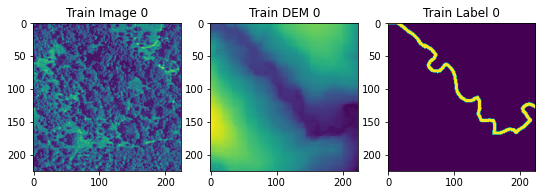




Sample 1


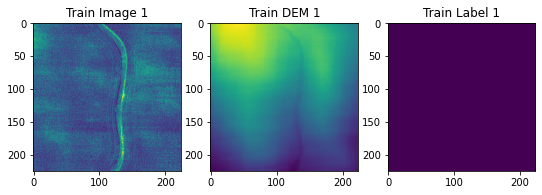




Sample 2


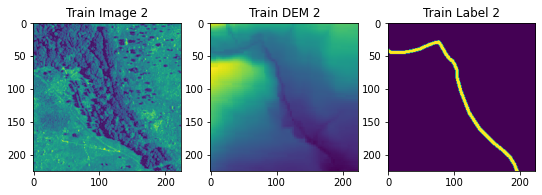




Sample 3


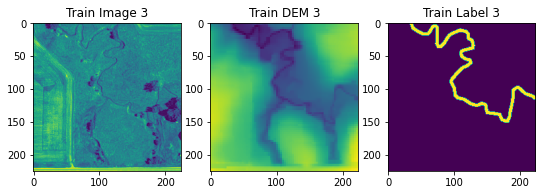




Sample 4


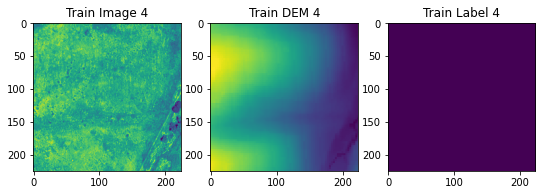




Sample 5


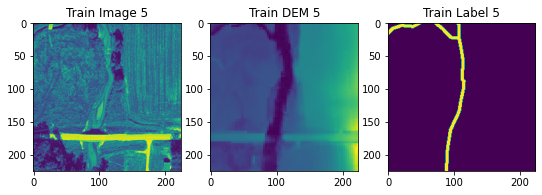




Sample 6


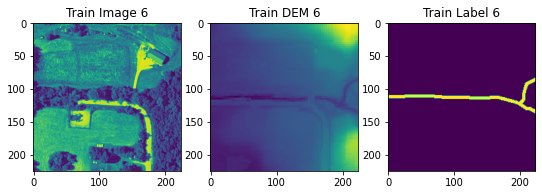




Sample 7


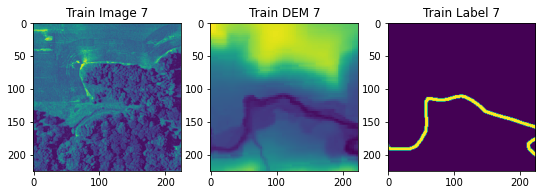




Sample 8


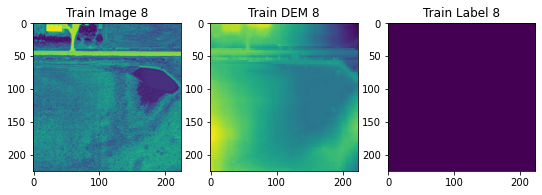




Sample 9


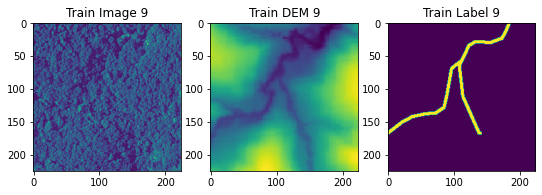

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Number of samples to show
sample_count = 10

for i in range(sample_count):
    t_choice = np.random.randint(0, len(X_train)-1)
    
    y_tile = np.squeeze(Y_train[t_choice])
    
    x_tile = X_train[t_choice]
    x_tile = np.moveaxis(x_tile, -1, 0)
    
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(9,4))
    
    print('\n\n\nSample {}'.format(i))
    ax1.imshow(x_tile[0])
    ax1.set_title('Train Image {}'.format(i))
        
    ax2.imshow(x_tile[4])
    ax2.set_title('Train DEM {}'.format(i))
    
    ax3.imshow(y_tile)
    ax3.set_title('Train Label {}'.format(i))
    
    plt.show()

In [7]:
# Save Offsets to csv files so the same windows may be resampled during iteration
t.WriteOffsets('Training', train_offsets, '{}/train_offsets.csv'.format(tensor_folder))
t.WriteOffsets('Validation', val_offsets, '{}/val_offsets.csv'.format(tensor_folder))


""" Save all tensors """
np.save('{}/X_train'.format(tensor_folder), X_train)
np.save('{}/Y_train'.format(tensor_folder), Y_train)

np.save('{}/X_val'.format(tensor_folder), X_val)
np.save('{}/Y_val'.format(tensor_folder), Y_val)

np.save('{}/X_test'.format(tensor_folder), X_test)
np.save('{}/Y_test'.format(tensor_folder), Y_test)

## Write Metadata to Markdown

In [8]:

from datetime import datetime as dt 


### Write test data to markdown
markdown_fp = os.path.join(tensor_folder, 'tensor_info_{:02}.md'.format(set_idx))
md = open(markdown_fp, 'w+')

# Header / Notes
md.write("# Tensor Set {:02}\n\n".format(set_idx))


md.write(dt.now().strftime('\n\n%a at %I:%M:%S%p'))

md.write('\n</br>\n\n')

md.write('### Parameters:\n')
md.write(' - Buffer: {}\n'.format(label_buffer))
md.write(' - Testing Target: {}\n'.format(test_target))
md.write(' - Training Target: {}\n'.format(train_target))
md.write(' - Validation Target: {}\n'.format(val_target))

md.write('\n</br>\n\n')

md.write('### Tensors:\n')
md.write('Training:\n')
md.write(' - X_Train: {}\n'.format(X_train.shape))
md.write(' - Y_Train: {}\n'.format(Y_train.shape))
md.write('Validation:\n')
md.write(' - X_Validation: {}\n'.format(X_val.shape))
md.write(' - Y_Validation: {}\n'.format(Y_val.shape))
md.write('Testing:\n')
md.write(' - X_Test: {}\n'.format(X_test.shape))
md.write(' - Y_Test: {}\n'.format(X_test.shape))

md.close()